In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
meta = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep = '\t', 
                   header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [3]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

plots = []

with open("MovieSummaries/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

42303it [00:01, 26877.77it/s]


In [4]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

100%|██████████| 42303/42303 [00:00<00:00, 1152220.86it/s]


In [5]:
# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [6]:
                    
                    ############################################
                    #   Data Exploration and Pre-processing    #
                    ############################################
#Let’s add the movie names and their genres from the movie metadata file 
#by merging the latter into the former based on the movie_id column:

In [7]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], 
                  on = 'movie_id')

print("movies.head()",movies.head())
print("movies['genre'][0]",movies['genre'][0])

movies.head()    movie_id  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                          plot  \
0                                                                                                                           Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.   
1  The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an

In [8]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
    genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

imdb_genre_list = ["Action","Adult","Adventure","Animation","Biography","Comedy","Crime","Documentary","Drama",
"Family","Fantasy","Film-Noir","Game-Show","History","Horror","Musical","Music","Mystery",
"News","Reality-TV","Romance","Sci-Fi","Short","Sport","Talk-Show","Thriller","War","Western"]
movies.genre_new=[[y for y in x if y in imdb_genre_list] for x in movies.genre_new]

# an empty list
genres = [] 

# extract genres
for i in movies['genre_new']: 
    genres.append(i) 

In [9]:
#Some of the samples might not contain any genre tags. We should remove those 
#samples as they won’t play a part in our model building process:

In [10]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

print("movies_new.shape",movies_new.shape, "movies.shape", movies.shape)

movies_new.shape (37519, 5) movies.shape (42204, 5)


In [11]:
#Notice that the genres are now in a list format. 
#Are you curious to find how many movie genres have been covered in this 
#dataset? The below code answers this question:

In [12]:
# get all genre tags in a list
all_genres = sum(genres,[])

print("len(set(all_genres)):", len(set(all_genres)))
set_genres = set(all_genres)

len(set(all_genres)): 18


In [13]:
# There are over 363 unique genre tags in our dataset. 
# That is quite a big number. I can hardy recall 5-6 genres! 
# Let’s find out what are these tags. We will use FreqDist( ) from the 
# nltk library to create a dictionary of genres and their occurrence count 
# across the dataset:

In [14]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [15]:
# I personally feel visualizing the data is a much better method than 
# simply putting out numbers. So, let’s plot the distribution of the 
# movie genres:

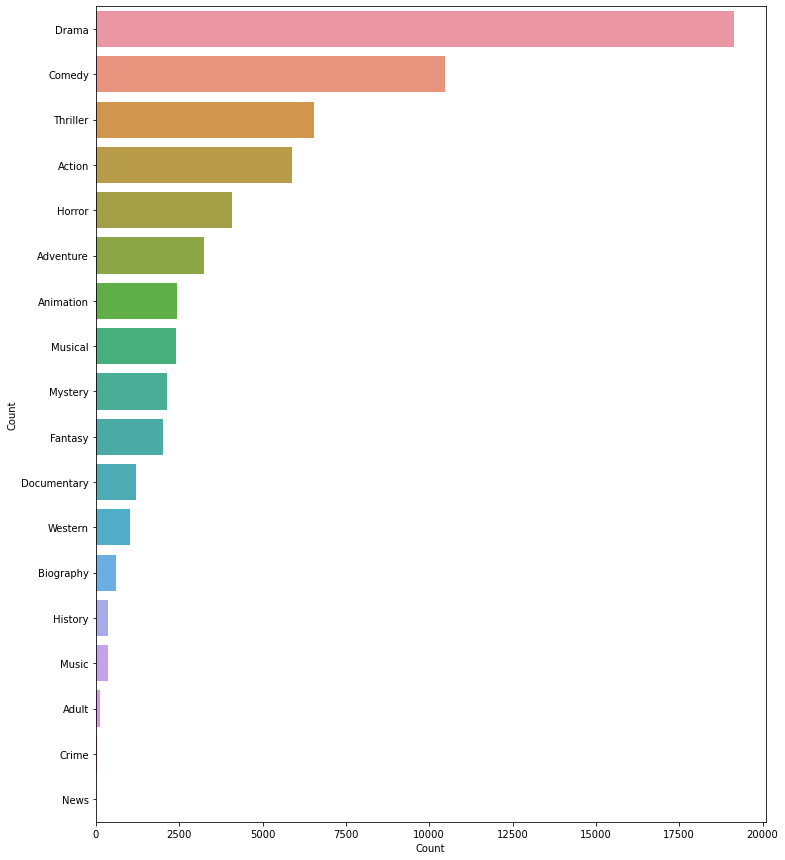

In [16]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [17]:
# Next, we will clean our data a bit. I will use some very basic text cleaning
# steps (as that is not the focus area of this article):

In [18]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [19]:
# Let’s apply the function on the movie plots by using the apply-lambda duo:

In [20]:
 movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

<ipython-input-20-cba7721b10bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))


In [21]:
# In the clean_plot column, all the text is in lowercase and there are also no 
# punctuation marks. Our text cleaning has worked like a charm.

# The function below will visualize the words and their frequency in a set 
# of documents. Let’s use it to find out the most frequent words in the movie
# plots column:

In [22]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

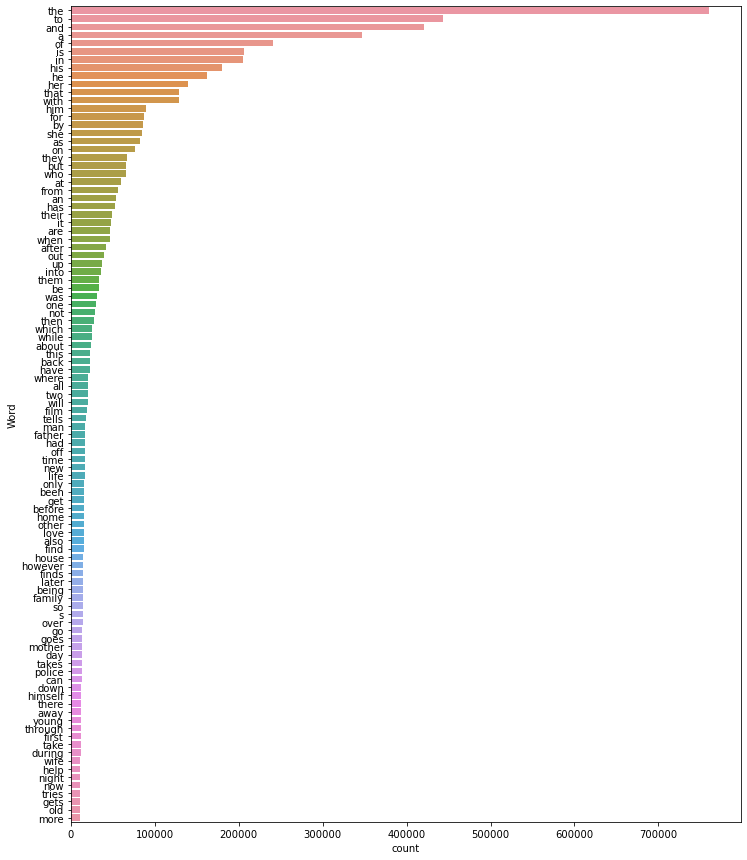

In [23]:
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [24]:
# Most of the terms in the above plot are stopwords. These stopwords carry far
# less meaning than other keywords in the text (they just add noise to the 
#data). I’m going to go ahead and remove them from the plots’ text. 
#You can download the list of stopwords from the nltk library:

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ugur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<ipython-input-26-4b15b8e74633>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))


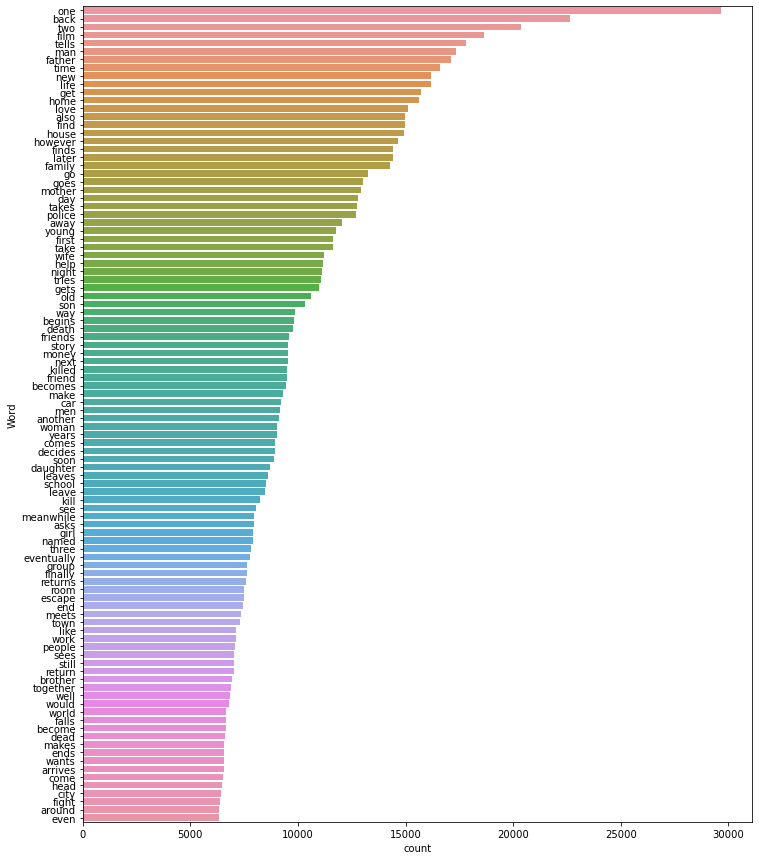

In [26]:
# Let’s remove the stopwords:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

#Check the most frequent terms sans the stopwords:

freq_words(movies_new['clean_plot'], 100)

In [27]:
                ###################################
                #   Converting Text to Features   #
                ###################################

# I mentioned earlier that we will treat this multi-label classification 
# problem as a Binary Relevance problem. Hence, we will now one hot encode 
# the target variable, i.e., genre_new by using sklearn’s 
# MultiLabelBinarizer( ). Since there are 363 unique genre tags, 
# there are going to be 363 new target variables.

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [29]:
# Now, it’s time to turn our focus to extracting features from the cleaned 
# version of the movie plots data. For this article, I will be using TF-IDF 
# features. Feel free to use any other feature extraction method you are 
# comfortable with, such as Bag-of-Words, word2vec, GloVe, or ELMo.

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [31]:
# I have used the 10,000 most frequent words in the data as my features. 
# You can try any other number as well for the max_features parameter.

# Now, before creating TF-IDF features, we will split our data into train and 
# validation sets for training and evaluating our model’s performance. 
# I’m going with a 80-20 split – 80% of the data samples in the train set and 
# the rest in the validation set:
    

In [32]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [33]:
#Now we can create features for the train and the validation set:

In [34]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [35]:
                ###############################################
                #   Build Your Movie Genre Prediction Model   # 
                ###############################################

# We are all set for the model building part! This is what we’ve been waiting 
# for.

# Remember, we will have to build a model for every one-hot encoded target 
# variable. Since we have 363 target variables, we will have to fit 
# 363 different models with the same set of predictors (TF-IDF features).

# As you can imagine, training 363 models can take a considerable amount of 
# time on a modest system. Hence, I will build a Logistic Regression model as 
# it is quick to train on limited computational power:

In [36]:
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score,accuracy_score

In [37]:
# We will use sk-learn’s OneVsRestClassifier class to solve this problem 
# as a Binary Relevance or one-vs-all problem:

In [38]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [39]:
# Finally, fit the model on the train set:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [40]:
#Predict movie genres on the validation set:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [41]:
#Let’s check out a sample from these predictions:
print(y_pred[3])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [42]:
# It is a binary one-dimensional array of length 363. Basically, it is the 
# one-hot encoded form of the unique genre tags. We will have to find a way 
# to convert it into movie genre tags.

# Luckily, sk-learn comes to our rescue once again. We will use the 
# inverse_transform( ) function along with the MultiLabelBinarizer( ) 
# object to convert the predicted arrays into movie genre tags:

In [43]:
print(multilabel_binarizer.inverse_transform(y_pred)[3])

('Drama',)


In [44]:
# evaluate performance
f1_score_nlp = f1_score(yval, y_pred, average="micro")
print(f"F1 score NLP = {f1_score_nlp}")

F1 score NLP = 0.5391622983357931


In [45]:
                    #################################
                    #   Create Inference Function   #
                    #################################

# Wait – we are not done with the problem yet. We also have to take care of 
# the new data or new movie plots that will come in the future, right? Our 
# movie genre prediction system should be able to take a movie plot in raw 
# form as input and generate its genre tag(s).

# To achieve this, let’s build an inference function. It will take a movie 
# plot text and follow the below steps:

# * Remove stopwords from the cleaned text
# * Extract features from the text
# * Make predictions
# * Return the predicted movie genre tags

In [46]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [47]:
# Let’s test this inference function on a few samples from our validation set:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", movies_new['movie_name'][k], 
        "\nPredicted genre: ", infer_tags(xval[k]))
    print("Actual genre: ",movies_new['genre_new'][k], "\n")
    

Movie:  Sorority House Massacre 
Predicted genre:  [('Horror', 'Thriller')]
Actual genre:  ['Horror'] 

Movie:  Bheema 
Predicted genre:  [('Action', 'Drama')]
Actual genre:  ['Action'] 

Movie:  Dr. Mabuse the Gambler 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Mystery'] 

Movie:  On the Beat 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama'] 

Movie:  Magician 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Thriller', 'Horror', 'Comedy'] 



In [48]:
                    #################################
                    #   Try with skumultilearn      #
                    #################################

In [ ]:
from skmultilearn.problem_transform import LabelPowerset
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(xtrain_tfidf, ytrain)
lp_predictions = lp_classifier.predict(xval_tfidf)
print("Accuracy = ",accuracy_score(yval,lp_predictions))
f1_score_skumultilearn = f1_score(yval,lp_predictions, average="micro")
print(f"F1 score skumultilearn = {f1_score_skumultilearn}")

In [ ]:
                    #################################
                    #   Try with Keras              #
                    #################################

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# load dataset
n_inputs, n_outputs = xtrain_tfidf.shape[1], ytrain.shape[1]
print(f"n_inputs:{n_inputs}, n_outputs:{n_outputs}")
# get model
model = Sequential()
model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# fit the model on all data
model.fit(xtrain_tfidf, ytrain, epochs=100)

In [ ]:
# make a prediction for new data
yhat = model.predict(xval_tfidf)
print(f'Predicted: {yhat[0]}')

In [ ]:
yhat[yhat>=0.5] = 1
yhat[yhat<0.5] = 0

In [ ]:
# evaluate performance
f1_score_keras = f1_score(yval, yhat, average="micro")
print(f"F1 score Keras = {f1_score_keras}")